In [1]:
import os
import trompy as tp
import numpy as np

%run "..//src//vgp_helper_fx"

In [2]:
ROOT_FOLDER = "C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2"

DATA_FOLDER = os.path.join(ROOT_FOLDER, "Processed\\s2p")
BEHAV_FOLDER = os.path.join(ROOT_FOLDER, "Bonsai\\")
METAFILE = os.path.join(ROOT_FOLDER, "Metafile_VGP2.3.xls")
rows, header = tp.metafilereader(METAFILE, sheetname="2panalysispilot")


File is excel file. Making csv metafile first


In [3]:
# Goes through metafile assembling data from s2p files where possible

cell_data={}

for row in rows:
    try:
        key=row[0]+'_'+row[1]
        animal=row[0]
        day=row[1]
        date=int(row[3])
        events=row[5]
        
        s2p_folder = os.path.join(DATA_FOLDER, "sub-{}\\ses-{}".format(animal, day))
        events_file =BEHAV_FOLDER+events
        
        
        cell_data[key] = assemble_data(s2p_folder,events_file)
        cell_data[key]['animal'] = row[0]
        cell_data[key]['diet'] = row[4]
        cell_data[key]['solution'] = row[2]
#         print(s2p_folder)
        
    except FileNotFoundError:
        print('Cannot find file for', key)
     

In [4]:
cols = ["animal", "diet", "solution", "lick_activated"]
df_activated = pd.DataFrame(columns=cols)

for key, d in cell_data.items():
    percent_act = d["df_responsive"].loc["lick_all", "activated"] / np.sum(d["df_responsive"].loc['pump_only':'neither',"activated"]) * 100
    data = np.array([d["animal"], d["diet"], d["solution"], percent_act])
    df_temp = pd.DataFrame({col: value for col, value in zip(cols, data)},
                          index=[key.split("_")[0]]).astype({'lick_activated':'float'})
    

    df_activated = pd.concat([df_activated, df_temp])
    
    
# df_activated

In [5]:
df_pref = (df_activated.pivot_table(index=["animal", "diet"],
                         columns=["solution"],
                         values="lick_activated",
                         aggfunc="mean")
             .astype({"Cas": "float", "Malt": "float"})
#              .assign(pref=lambda df_: df_.cas / (df_.cas + df_.malt))
             .assign(pref=lambda df_: df_.Cas - df_.Malt)
            )


In [6]:
df_pref

solution           Cas       Malt       pref
animal diet                                 
VGP202 NR    30.576923  28.386809   2.190114
       NRPR  20.238095  22.794118  -2.556022
VGP203 PR    22.329060  29.901961  -7.572901
       PRNR  21.097561  26.339286  -5.241725
VGP302 PR    59.189723  35.436508  23.753215
       PRNR  40.000000  16.176471  23.823529
VGP310 NR    22.775901  41.394928 -18.619027
       NRPR  22.500000  13.888889   8.611111
VGP402 PR     3.571429   1.724138   1.847291
       PRNR  16.078431  11.759868   4.318563
VGP403 NR    22.673993  18.993506   3.680486
       NRPR  24.036511  14.783654   9.252857
VGP404 NR     8.000000   9.769231  -1.769231
       NRPR  13.928571  13.571429   0.357143
VGP501 NR    23.621554  31.501548  -7.879994
       NRPR  46.696429  26.494565  20.201863
VGP502 NR     8.333333   5.128205   3.205128
       NRPR  21.791188  10.436433  11.354755
VGP503 NR    26.224662  15.555556  10.669107
       NRPR  25.000000  11.397849  13.602151
VGP505 PR    54.238619  26.970366  27.268253
       PRNR  32.500000  23.583157   8.916843
VGP506 PR    43.962848  10.690789  33.272059
       PRNR  15.384615  14.264706   1.119910
VGP509 PR    29.579741  25.106838   4.472904
       PRNR  28.285182  21.954023   6.331159

In [8]:
PRs = ["PR"]
NRs = ["NR"]

(df_pref
 .droplevel(0)
 .pref
 .reset_index()
 .query("diet in @PRs")
 .mean()
#  .loc["PR"]
)



pref    13.840137
dtype: float64

Dataframes for each group (NR and PR) Casein and maltodextrin activated cells

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making dataframe for NR-NRPR group
df_NR_cas = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Cas")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

df_NR_malt = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Malt")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

# Making dataframe for PR-PRNR group
df_PR_cas = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Cas")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)

df_PR_malt = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="Malt")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)


print(df_NR_malt)
print(df_NR_cas)
print(df_PR_malt)
print(df_PR_cas)



diet           NR       NRPR
animal                      
VGP202  28.386809  22.794118
VGP310  41.394928  13.888889
VGP403  18.993506  14.783654
VGP404   9.769231  13.571429
VGP501  31.501548  26.494565
VGP502   5.128205  10.436433
VGP503  15.555556  11.397849
diet           NR       NRPR
animal                      
VGP202  30.576923  20.238095
VGP310  22.775901  22.500000
VGP403  22.673993  24.036511
VGP404   8.000000  13.928571
VGP501  23.621554  46.696429
VGP502   8.333333  21.791188
VGP503  26.224662  25.000000
diet           PR       PRNR
animal                      
VGP203  29.901961  26.339286
VGP302  35.436508  16.176471
VGP402   1.724138  11.759868
VGP505  26.970366  23.583157
VGP506  10.690789  14.264706
VGP509  25.106838  21.954023
diet           PR       PRNR
animal                      
VGP203  22.329060  21.097561
VGP302  59.189723  40.000000
VGP402   3.571429  16.078431
VGP505  54.238619  32.500000
VGP506  43.962848  15.384615
VGP509  29.579741  28.285182


Figure for cells activated by casein and maltodextrin

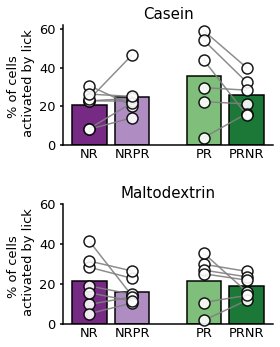

In [19]:
NR_cas=[]
NRPR_cas=[]
for row in df_NR_cas.iterrows():
    NR_cas.append(row[1].NR)
    NRPR_cas.append(row[1].NRPR)

NR_malt=[]
NRPR_malt=[]
for row in df_NR_malt.iterrows():
    NR_malt.append(row[1].NR)
    NRPR_malt.append(row[1].NRPR)
    
    
PR_cas=[]
PRNR_cas=[]
for row in df_PR_cas.iterrows():
    PR_cas.append(row[1].PR)
    PRNR_cas.append(row[1].PRNR)

PR_malt=[]
PRNR_malt=[]
for row in df_PR_malt.iterrows():
    PR_malt.append(row[1].PR)
    PRNR_malt.append(row[1].PRNR)

    

colors_1=['#762a83', '#af8dc3','#7fbf7b','#1b7837']


f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.5, bottom=0.05, left=0.25)

tp.barscatter([[NR_cas,NRPR_cas],[PR_cas,PRNR_cas]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['NR', 'NRPR', 'PR', 'PRNR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[0],
              show_legend=False)

tp.barscatter([[NR_malt,NRPR_malt],[PR_malt,PRNR_malt]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['NR', 'NRPR', 'PR', 'PRNR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[1],
              show_legend=False)

ax[0].set_ylabel('% of cells \n activated by lick',fontsize = 13)
ax[0].set_yticks([0,20,40,60])
ax[0].set_yticklabels([0,20,40,60], fontsize = 13)

ax[1].set_ylabel('% of cells \n activated by lick',fontsize = 13)
ax[1].set_yticks([0,20,40,60])
ax[1].set_yticklabels([0,20,40,60], fontsize = 13)


ax[0].set_title('Casein', fontsize =15)
ax[1].set_title('Maltodextrin', fontsize =15)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\%_lick_activated_cells.png')

Dataframes for each group (NR and PR) Preferense

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making dataframe for NR-NRPR group
df_NR = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR)
 .drop(columns=["PR", "PRNR"])
 .dropna()
)

# Making dataframe for PR-PRNR group
df_PR = (df_pref
 .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_:df_.PR,
         PRNR=lambda df_:df_.PRNR)
 .drop(columns=["NR", "NRPR"])
 .dropna()
)

# print(df_NR)
# print(df_PR)





Figure for proportion of cells activated by casin - malodextrin

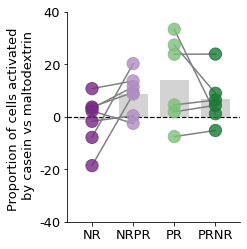

In [18]:
f, ax = plt.subplots(figsize=(4,4))
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.3)


x1 = [1,2]
x2=[3,4]
for row in df_NR.iterrows():
    y = [row[1].NR,row[1].NRPR]
#     print(y)
    ax.plot(x1, y, color="grey")
    ax.scatter(x1, y, s=150, color=["#762a83", "#af8dc3"], zorder=20, alpha=0.8)

for row in df_PR.iterrows():
    y = [row[1].PR,row[1].PRNR]
#     print(y)
    ax.plot(x2, y, color="grey")
    ax.scatter(x2, y, s=150, color=["#7fbf7b", "#1b7837"], zorder=20, alpha=0.8)

  
    
ax.bar(x1, [df_NR.NR.mean(), df_NR.NRPR.mean()], width=0.7, zorder=-1, color="lightgrey")
ax.bar(x2, [df_PR.PR.mean(), df_PR.PRNR.mean()], width=0.7, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Proportion of cells activated \n by casein vs maltodextrin", size=13)
ax.set_yticks([-40,-20,0,20,40])
ax.set_yticklabels(['-40','-20','0','20','40'], size=13)

ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["NR", 'NRPR','PR','PRNR'], size=13)
ax.set_xlim([0.4,4.6])

ax.axhline(0, color="k", linestyle="--", zorder=-1,lw=1.2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\pref_casein_cells.png')

In [13]:
df_diet1 = (df_pref
#  .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_: df_.PR,
         PRNR=lambda df_:df_.PRNR,
         NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR,
)
 .drop(columns=["NRPR", "PRNR"])
)



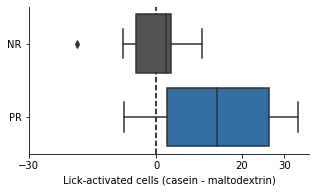

In [14]:
my_colors = {'NR': '#525252', 'PR': '#2171b5'}

'','','',''
f, ax = plt.subplots(figsize=(6,3),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})

sns.boxplot(data=df_diet1,orient="h", ax=ax, palette=my_colors)


ax.set_ylabel("")
ax.set_yticklabels(["NR", "PR"])
ax.set_xticks([-30, 0, 20, 30])
ax.set_xlabel("Lick-activated cells (casein - maltodextrin)")

ax.axvline(0, color="k", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# f.savefig("..//output//grouped_casmalt_diff.png")

In [17]:
df_boxplot = (df_pref
#  .reset_index()
 .pivot_table(index="animal",
              columns="diet",
              values="pref")
#  .fillna(0)
 .assign(PR=lambda df_: df_.PR,
         PRNR=lambda df_:df_.PRNR,
         NR=lambda df_:df_.NR,
         NRPR=lambda df_:df_.NRPR,
)
#  .drop(columns=["NRPR", "PRNR"])
)





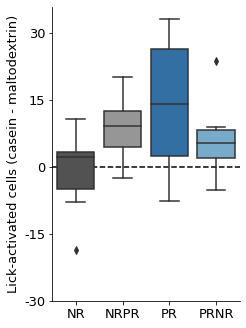

In [16]:
my_colors = {'NR': '#525252', 'NRPR': '#969696', 'PR': '#2171b5','PRNR':'#6baed6'}

'','','',''
f, ax = plt.subplots(figsize=(4,6),
                     gridspec_kw={"left": 0.25, "bottom": 0.2})


sns.boxplot(data=df_boxplot,orient="v", ax=ax, palette=my_colors)


ax.set_xlabel("")
ax.set_xticklabels(["NR",'NRPR', "PR", 'PRNR'],size=13)
ax.set_yticks([-30, -15,0, 15, 30])
ax.set_yticklabels(['-30','-15', '0', '15', '30'],size=13)
ax.set_ylabel("Lick-activated cells (casein - maltodextrin)",size=13)

ax.axhline(0, color="k", linestyle="--", zorder=-1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# f.savefig("..//output//grouped_casmalt_diff.png")

In [220]:
sns.boxplot?

Signature:
sns.boxplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    fliersize=5,
    linewidth=None,
    whis=1.5,
    ax=None,
    **kwargs,
)
Docstring:
Draw a box plot to show distributions with respect to categories.

A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A 